In [1]:
import numpy as np, pandas as pd
from glob import glob
from astropy.table import Table
from matplotlib import pyplot as plt, colors as colors, colorbar as cbar
from astroquery.simbad import Simbad
import astropy.coordinates as coord
import astropy.units as u

%matplotlib inline

In [2]:
good = pd.read_csv('../data/bright_sample/massive.csv.gz')
len(good)

6484

In [116]:
#We need a list of LBVs because SIMBAD is bad at classifying LBVs
#Let's go with only confirmed LBVs from Richardson & Mehner (2018, RNAAS)

lbv_commonname1 = ['HD 90177','* eta Car','V* AG Car','MR 35','[GKM2012] WS1',
                   'WRAY 16-137','EM* VRMF   55','Cl* Westerlund 1 W 243','[GKF2010] MN48',
                   'HD 160529','[GKF2010] MN58','GCIRS 34W','[NHS93] 22','[GMC99] D6',
                   'HD 168607','EM* MWC 930','V* V481 Sct','IRAS 18576+0341','* P Cyg',
                   'HD 5980','HD 6884','HD 269006','HD 269216','V* S Dor','HD 269582',
                   'HD 269662','HD 269700','HD 269858','CPD-69   463']

lbv_commonname2 = ['V* HR Car','HD 93308','HD 94910','V* V432 Car',
                   'UCAC2 3729120','2MASS J13501536-6148552','[GKF2010] MN44',
                   '2MASS J16470749-4552290','2MASS J16493770-4535592','V* V905 Sco',
                   '2MASS J17374754-3137333','WR 101db','V* V4998 Sgr',
                   'V* V4650 Sgr','V* V4029 Sgr','V* V446 Sct','G24.73+0.69',
                   'V* V1672 Aql','HD 193237','RMC 14','RMC 40','RMC 71',
                   '2MASS J05133077-6932236','HD 35343','SV* HV 5495',
                   '2MASS J05305147-6902587','RMC 116','RMC 127','RMC 143']

lbv_gaia = [5255045082580350080,5350358580171706624,5338220285385672064,5337309477433273728,
            5864989022016713728,5865577604279098112,5940576971716473344,5940105830990286208,
            5940216130049700480,4053887521876855808,4055062727939772800,                  0,                  
                              0,                  0,4097791502146559872,4159973866869462784,
            4255908794692238848,                  0,2061242908036996352,4690516883290136832,
            4687436704549343488,4654621505126284288,4658204053297963392,4658193814095915776,
            4658481718680657792,4658431553453824256,4658474743652257664,4657655435693883776,
            4657679551902223616]

#Note: [GKF2010] MN58 is close to Gaia DR2 4055062727939772800 = 2MASS J17374754-3137333, 
#so we're calling them the same source

In [117]:
#Checking we did this ok
len(lbv_commonname1),len(lbv_commonname2),len(lbv_gaia)

(29, 29, 29)

In [244]:
#Let's write a decision tree that classifies things

#LBV -> Binaries -> WRs -> Cool stars -> Warm stars -> Oe/Be (brackets?) -> OB supergiants/main sequence

classifications= []
for i,row in good.iterrows():
    # Pull out lbvs
    if (row['source_id'] in lbv_gaia) | (row['CommonName'] in lbv_commonname1) | (row['CommonName'] in lbv_commonname2):
        classifications.append('LBV')
    # Pull out remaining binaries
    elif ('EB' in str(row['SimbadOType'])) | ('SB' in str(row['SimbadOType'])) | ('Ellip' in str(row['SimbadOType'])) | ('HMXB' in str(row['SimbadOType'])) | ('+' in str(row['SpT'])[1:-2]) | (str(row['SpT']) == 'B+K'):
        classifications.append('Binary')
    # Pull out WRs. Note, we also get the Ofpe/WN9 LBV candidate HD 269445
    elif ('W' in str(row['SpT'])) | (row['SimbadOType'] == 'WR*'):
        classifications.append('WR')
    #Cool stars
    elif (str(row['SpT'])[0] in ['K','M']):
        classifications.append('RSG')
    #Warm stars
    elif (str(row['SpT'])[0] in ['F','G']):
        classifications.append('YSG')
    #O/B [e] stars
    elif '[e]' in str(row['SpT']):
        classifications.append('OB[e]')
    #O/B/A e stars
    elif np.any(['e' in foo for foo in str(row['SpT']).split('pec')]) | ('Em' in str(row['SimbadOType'])):
        classifications.append('OBAe')
    elif (str(row['SpT'])[0] in ['O','B','A']):
        #OBA subgiants and giants
        if ('IV' in str(row['SpT']))|('III' in str(row['SpT'])):
            classifications.append('EvolvedOBA')
        #OBA dwarfs
        elif 'V' in str(row['SpT']):
            classifications.append('MainSequenceOBA')
        #OBA bright giants and supergiants
        elif ('I' in str(row['SpT'])) | ('SG' in str(row['SimbadOType'])):
            classifications.append('SupergiantOBA')
        #Generic OBA
        else:
            classifications.append('OBA')
    #C and S stars
    elif ('C' in str(row['SpT'])) | (str(row['SimbadOType']) == 'C*'):
        classifications.append('CStar')
    elif 'S' in str(row['SpT']):
        classifications.append('SStar')
    #Everything else. This includes 'Candidate' other types, as well as LPVs, semi-regular Variables, etc.
    elif 'V*' in str(row['SimbadOType']):
        classifications.append('Misc. Variable')
    else:
        classifications.append('Unknown/Candidate')
print(len(classifications))

6484


In [245]:
classification_df = pd.DataFrame({'source_id':good['source_id'],
                                  'CommonName':good['CommonName'],
                                  'Class':classifications})
classification_df.to_csv('classifications.csv')

ValueError: 'c' argument has 7 elements, which is not acceptable for use with 'x' with size 6, 'y' with size 6.

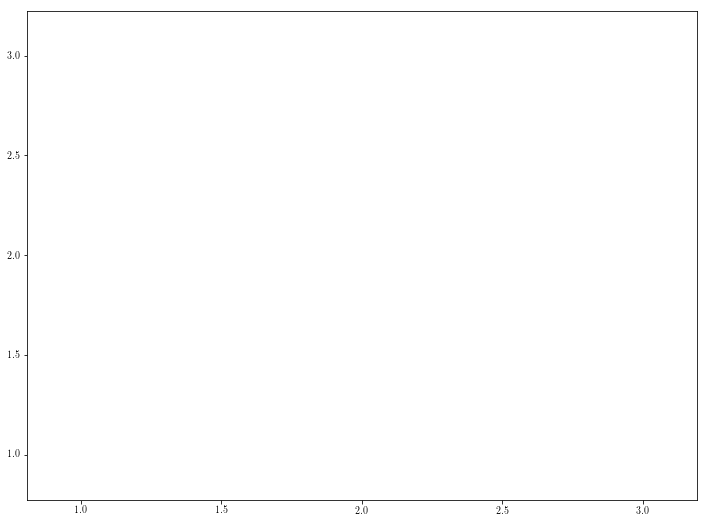

In [263]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

plt.figure(figsize = (12,9))

From = ['Is LBV?', 'Is Binary?', 'Is WR?', 'Is RSG?', 'Is YSG?', 'Is OB[e]?', 'Is OBAe?',
        'Is OBA?'
        "Greenhouse\nGas\nEmissions",'Climate\nChange','Climate\nFeedbacks','Greenhouse\nGas\nEmissions',
        'Climate\nChange']
To = ["Greenhouse\nGas\nEmissions", "Greenhouse\nGas\nEmissions",
      "Greenhouse\nGas\nEmissions",'Climate\nChange','Climate\nFeedbacks','Greenhouse\nGas\nEmissions',
      'Climate\nChange','Everyone$^{Dies}$']

df = pd.DataFrame({ 'from':From,
                   'to':To})
# Define Node Positions
pos = {'Is LBV?':(1,1),
        'Class = LBV':(2,1),
        'Is Binary?' : (2,2),
        'Class = Binary':(3,1),
        'Is WR?' : (3,2),
        'Class = WR':(4,1),
        'Is RSG?' : (4,2),
        'Class = RSG':(5,1),
        'Is YSG?' : (5,2),
        'Class = YSG':(6,1),
        'Is OB[e]?' : (6,2),
        'Class = OB[e]':(7,1),
        'Is OBAe?' : (7,2),
        'Class = OBAe':(8,1),
        'Is OBA?' : (8,2),
        'Luminosity Class\nIV or III?':(9,1),
        'Is C Star?':(9,2),
        'Class = Evolved OBA':(10,1),
        'Luminosity Class V?':(10,2),
        'Class = C Star':(10,3),
        'Is S Star?':(10,4),
        'Class = Main Sequence OBA':(11,1),
        'Luminosity Class I?':(11,2),
        'Class = S Star':(11,3),
        'Variable?':(11,4),
        'Class = Supergiant OBA':(12,1),
        'Class = OBA':(12,2)
        'Class = Misc. Variable':(12,3),
        'Class = Unknown/Candidate':(12,4)}

# Define Node Colors
NodeColors = {'Is LBV?':[1,1,1],
        'Class = LBV':[1,1,1],
        'Is Binary?' : [1,1,1],
        'Class = Binary':[1,1,1],
        'Is WR?' : [1,1,1],
        'Class = WR':[1,1,1],
        'Is RSG?' : [1,1,1],
        'Class = RSG':[1,1,1],
        'Is YSG?' : [1,1,1],
        'Class = YSG':[1,1,1],
        'Is OB[e]?' : [1,1,1],
        'Class = OB[e]':[1,1,1],
        'Is OBAe?' : [1,1,1],
        'Class = OBAe':[1,1,1],
        'Is OBA?' : [1,1,1],
        'Luminosity Class\nIV or III?':[1,1,1],
        'Is C Star?':[1,1,1],
        'Class = Evolved OBA':[1,1,1],
        'Luminosity Class V?':[1,1,1],
        'Class = C Star':[1,1,1],
        'Is S Star?':[1,1,1],
        'Class = Main Sequence OBA':[1,1,1],
        'Luminosity Class I?':[1,1,1],
        'Class = S Star':[1,1,1],
        'Variable?':[1,1,1],
        'Class = Supergiant OBA':[1,1,1],
        'Class = OBA':[1,1,1],
        'Class = Misc. Variable':[1,1,1],
        'Class = Unknown/Candidate':[1,1,1]}

Labels = {}
i = 0
for a in From:
    Labels[a]=a
    i +=1
Labels[To[-1]]=To[-1]

# Build your graph. Note that we use the DiGraph function to create the graph! This adds arrows
G=nx.from_pandas_edgelist(df, 'from', 'to', create_using=nx.DiGraph() )

# Define the colormap and set nodes to circles, but the last one to a triangle
Circles = []
Traingle = []
Colors = []
for n in G.nodes:
    if n != 'Everyone$^{Dies}$':
        Circles.append(n)
    else:
        Traingle.append(n)
    Colors.append(NodeColors[n])

# By making a white node that is larger, I can make the arrow "start" beyond the node
nodes = nx.draw_networkx_nodes(G, pos, 
                       nodelist = Circles,
                       node_size=1.25e4,
                       node_shape='o',
                       node_color='white',
                       alpha=1)

nodes = nx.draw_networkx_nodes(G, pos, 
                       nodelist = Circles,
                       node_size=1e4,
                       node_shape='o',
                       node_color=Colors,
                       edgecolors='black',
                       alpha=0.5)


nodes = nx.draw_networkx_nodes(G, pos, 
                       nodelist = Traingle,
                       node_size=1.25e4,
                       node_shape='>',
                       node_color='white',
                       alpha=1)

nodes = nx.draw_networkx_nodes(G, pos, 
                       nodelist = Traingle,
                       node_size=1e4,
                       node_shape='>',
                       node_color=Colors,
                       edgecolors='black',
                       alpha=0.5)


nx.draw_networkx_labels(G, pos, Labels, font_size=12)

# Again by making the node_size larer, I can have the arrows end before they actually hit the node
edges = nx.draw_networkx_edges(G, pos, node_size=1.8e4,
                               arrowstyle='->',width=2,arrowsizes=10)

plt.xlim(0,4.5)
plt.ylim(0,4)
plt.axis('off')
plt.show()

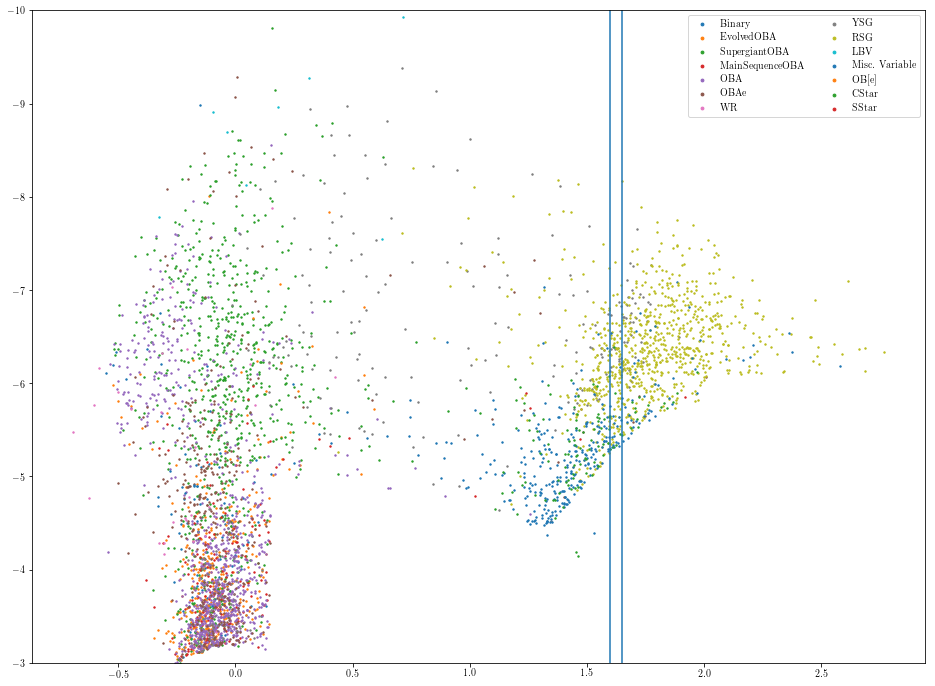

In [249]:
fig=plt.figure(figsize=(16,12))
joined = good.merge(classification_df,on='source_id')
for cl in joined['Class'].unique():
    if cl != 'Unknown/Candidate':
        plt.scatter(joined['BP-RP'][joined['Class']==cl],joined['M_G'][joined['Class']==cl],s=2,label=cl)
plt.ylim(-3,-10)
plt.legend(ncol=2,markerscale=2)

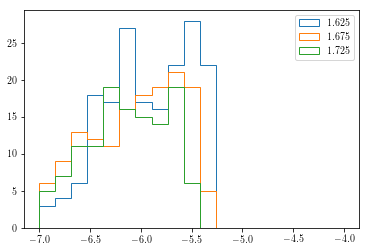

In [260]:
for center in [1.625,1.675,1.725]:
    plt.hist(good['M_G'][np.abs(good['BP-RP']-center) < 0.025],bins=np.linspace(-7,-4,20),label=str(center),histtype='step')
plt.legend()

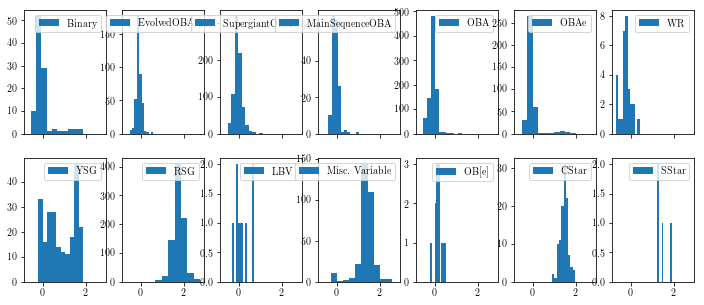

In [261]:
fig, ax = plt.subplots(2,7,figsize=(12,5),sharex=True)

for i,cl in enumerate(joined['Class'][joined['Class']!='Unknown/Candidate'].unique()):
    ax.flatten()[i].hist(joined['BP-RP'][joined['Class']==cl],label=cl)
    ax.flatten()[i].legend()

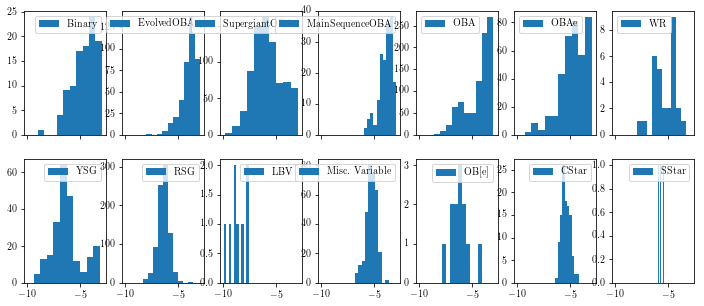

In [262]:
fig, ax = plt.subplots(2,7,figsize=(12,5),sharex=True)

for i,cl in enumerate(joined['Class'][joined['Class']!='Unknown/Candidate'].unique()):
    ax.flatten()[i].hist(joined['M_G'][joined['Class']==cl],label=cl)
    ax.flatten()[i].legend()

In [ ]:
#make color-color
#(G-J) - (J-W1) - (W1-W2) - (W2-W3)